In [1]:
from IPython.display import HTML

HTML('''
    <style> 
        body {font-family: "Roboto Condensed Light", "Roboto Condensed";} 
        h1 {padding: 10px 12px; background-color: #E64626; color: #ff0000; font-size: 50px;}
        h2 {padding: 10px 12px; background-color: #E64626; position: static; color: #ffffff; font-size: 40px;} 
        .text_cell_render p { font-size: 15px; } 
        .text_cell_render h1 { font-size: 30px; } 
        .text_cell_render h3 { padding: 10px 12px; background-color: #0148A4; position: static; color: #ffffff; font-size: 20px;} 
        h4:before{ content: "@"; font-family:"Wingdings"; font-style:regular; margin-right: 4px;} 
        .text_cell_render h4 {padding: 8px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #FFB800; color: #ffffff; font-size: 18px; text-align: center; border-radius: 5px;}
        input[type=submit] {background-color: #E64626; border: solid; border-color: #734036; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}
    </style>
''')

# Import library

In [49]:
import pandas as pd
import geopandas as gpd
import sqlalchemy
import seaborn as sns
from shapely import wkt, wkb
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import create_engine, text
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import psycopg2
import psycopg2.extras
import json
import plotly.express as px
import folium
from folium.plugins import HeatMap
import warnings

# SQL Connection Functions

In [3]:
credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['database']
        port       = db_conn_dict['port']
        try:
            db = create_engine(f'postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [4]:
crs = 'epsg:4326'
srid = 4326

In [5]:
db, conn = pgconnect(credentials)

Connected successfully.


In [6]:
conn.execute(text("""
CREATE SCHEMA IF NOT EXISTS Winter_Data_Analysis_Challenge;
COMMIT;
"""))
conn.execute(text("SET search_path TO Winter_Data_Analysis_Challenge"))

In [7]:
from sqlalchemy import inspect
inspect(db).get_schema_names()

['information_schema', 'winter_data_analysis_challenge']

In [8]:
conn.execute(text("CREATE EXTENSION IF NOT EXISTS postgis;"))

# Import data

## Life expectancy dataset

### Cleaning data

In [9]:
df_longevity =  pd.read_csv("data/life-expectancy.csv")
df_longevity.columns = ['entity', 'code', 'year', 'longevity']
df_longevity.dropna(subset = ['entity', 'year', 'longevity'], inplace = True)
df_longevity.drop_duplicates(subset = ['entity', 'year'], inplace = True)
df_longevity

,entity,code,year,longevity
0,Afghanistan,AFG,1950,27.7275
1,Afghanistan,AFG,1951,27.9634
2,Afghanistan,AFG,1952,28.4456
3,Afghanistan,AFG,1953,28.9304
4,Afghanistan,AFG,1954,29.2258
...,...,...,...,...
20750,Zimbabwe,ZWE,2017,60.7095
20751,Zimbabwe,ZWE,2018,61.4141
20752,Zimbabwe,ZWE,2019,61.2925
20753,Zimbabwe,ZWE,2020,61.1242


In [10]:
df_region = df_longevity[df_longevity['code'].isnull()]
df_region = df_region.drop(columns = ['code'])
df_region

,entity,year,longevity
72,Africa,1770,26.4000
73,Africa,1925,26.4000
74,Africa,1950,37.6235
75,Africa,1951,37.9309
76,Africa,1952,38.4430
...,...,...,...
19941,Upper-middle-income countries,2017,75.9064
19942,Upper-middle-income countries,2018,76.2589
19943,Upper-middle-income countries,2019,76.4784
19944,Upper-middle-income countries,2020,75.7449


### Longevity by countries dataframe

In [11]:
region_value = df_region['entity'].unique()
df_country = df_longevity[~df_longevity['entity'].isin(region_value)]
df_country = df_country.reset_index(drop = True)
df_country.columns = ['country', 'iso_code', 'year', 'longevity']

In [12]:
df_country[df_country['iso_code'].str.len() != 3]['iso_code'].unique() 

array(['OWID_KOS', 'OWID_USS', 'OWID_WRL'], dtype=object)

In [13]:
# Drop these records
df_country.drop(df_country[df_country['iso_code'].str.len() != 3].index, inplace = True)
df_country

,country,iso_code,year,longevity
0,Afghanistan,AFG,1950,27.7275
1,Afghanistan,AFG,1951,27.9634
2,Afghanistan,AFG,1952,28.4456
3,Afghanistan,AFG,1953,28.9304
4,Afghanistan,AFG,1954,29.2258
...,...,...,...,...
19056,Zimbabwe,ZWE,2017,60.7095
19057,Zimbabwe,ZWE,2018,61.4141
19058,Zimbabwe,ZWE,2019,61.2925
19059,Zimbabwe,ZWE,2020,61.1242


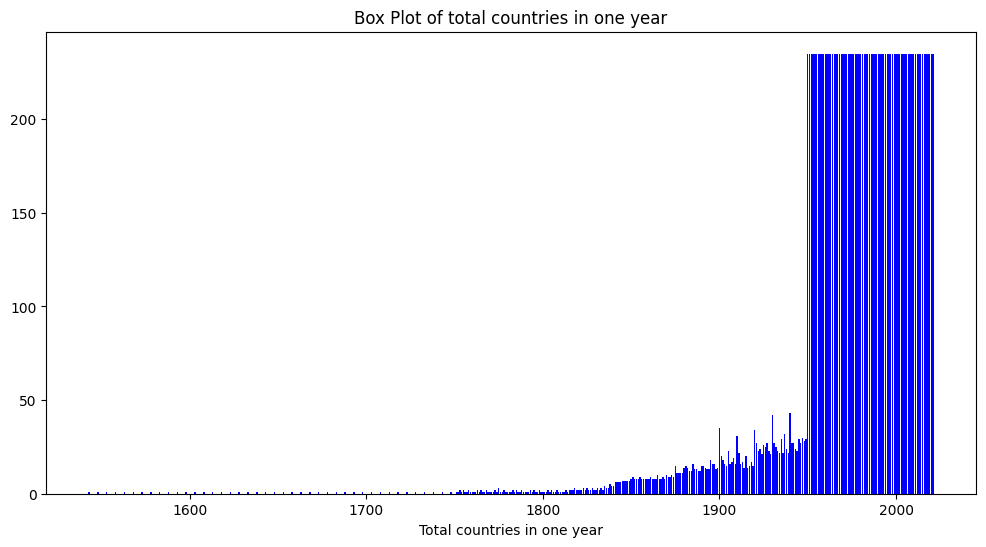

In [14]:
iso_code_counts_per_year = df_country.groupby('year')['iso_code'].nunique().reset_index()
iso_code_counts_per_year.columns = ['year', 'distinct_iso_code_count']


plt.figure(figsize=(12, 6))
plt.bar(iso_code_counts_per_year['year'], iso_code_counts_per_year['distinct_iso_code_count'], color = 'blue')
plt.title('Box Plot of total countries in one year')
plt.xlabel('Total countries in one year')
plt.show()

In [15]:
# Only take the data from 1950 to 2021
df_country.drop(df_country[df_country['year'] < 1950].index, inplace = True)
df_country

,country,iso_code,year,longevity
0,Afghanistan,AFG,1950,27.7275
1,Afghanistan,AFG,1951,27.9634
2,Afghanistan,AFG,1952,28.4456
3,Afghanistan,AFG,1953,28.9304
4,Afghanistan,AFG,1954,29.2258
...,...,...,...,...
19056,Zimbabwe,ZWE,2017,60.7095
19057,Zimbabwe,ZWE,2018,61.4141
19058,Zimbabwe,ZWE,2019,61.2925
19059,Zimbabwe,ZWE,2020,61.1242


In [16]:
year_counts_per_iso_code = df_country.groupby('iso_code')['year'].nunique().reset_index()
year_counts_per_iso_code.columns = ['iso_code', 'distinct_year_count']
filtered_year_counts = year_counts_per_iso_code[year_counts_per_iso_code['distinct_year_count'] != 72][['iso_code', 'distinct_year_count']]
filtered_year_counts
# The number of years per country is 72 for all countries.

,iso_code,distinct_year_count


In [17]:
print(df_country['iso_code'].unique().size)
print(df_country.shape[0])
# 235 * 72 = 16920

235
16920


In [18]:
df_country_copy = df_country.copy()
df_country_copy = df_country_copy.drop(columns = ['country'])
conn.execute(text("""
DROP TABLE IF EXISTS longevity_country CASCADE;
CREATE TABLE longevity_country (
    iso_code CHAR(3) NOT NULL,
    year INTEGER,
    longevity FLOAT
);
"""))
df_country_copy.to_sql('longevity_country', conn, if_exists='append', index=False)
query(conn, "select * from longevity_country")

,iso_code,year,longevity
0,AFG,1950,27.7275
1,AFG,1951,27.9634
2,AFG,1952,28.4456
3,AFG,1953,28.9304
4,AFG,1954,29.2258
...,...,...,...
16915,ZWE,2017,60.7095
16916,ZWE,2018,61.4141
16917,ZWE,2019,61.2925
16918,ZWE,2020,61.1242


### Longevity by continents dataframe

In [19]:
# Ignore data from "Latin America and the Carribeans" and "Northern America"
continent = ['Africa', 'Americas', 'Asia', 'Europe', 'Oceania']
df_continent = df_region[df_region['entity'].isin(continent)]
df_continent = df_continent.reset_index(drop = True)
df_continent.columns = ['region', 'year', 'longevity']

In [20]:
df_continent = df_continent[(df_continent['year'] >= 1950) & (df_continent['year'] <= 2021)]
year_counts_per_continent = df_continent.groupby('region')['year'].nunique().reset_index()
year_counts_per_continent.columns = ['category', 'distinct_year_count']
year_counts_per_continent

,category,distinct_year_count
0,Africa,72
1,Americas,72
2,Asia,72
3,Europe,72
4,Oceania,72


In [21]:
conn.execute(text(f"""
DROP TABLE IF EXISTS longevity_continent CASCADE;
CREATE TABLE longevity_continent (
    region VARCHAR(15),
    year INTEGER,
    longevity FLOAT
);
"""))
df_continent.to_sql('longevity_continent', conn, if_exists='append', index=False)
query(conn, "select * from longevity_continent")


,region,year,longevity
0,Africa,1950,37.6235
1,Africa,1951,37.9309
2,Africa,1952,38.4430
3,Africa,1953,38.9152
4,Africa,1954,39.2991
...,...,...,...
355,Oceania,2017,78.5432
356,Oceania,2018,78.8271
357,Oceania,2019,78.7485
358,Oceania,2020,79.4958


### Longevity by income dataframe

In [22]:
income_category = ['Low-income countries', 'Lower-middle-income countries', 'Middle-income countries', 'Upper-middle-income countries', 'High-income countries']
df_income = df_region[df_region['entity'].isin(income_category)]
df_income = df_income.reset_index(drop = True)
df_income.columns = ['category', 'year', 'longevity']

In [23]:
replacement_income =    {'Low-income countries': 'low',
                        'Lower-middle-income countries': 'lower-middle',
                        'Middle-income countries': 'middle',
                        'Upper-middle-income countries': 'upper-middle',
                        'High-income countries': 'high'
                        }
df_income = df_income.replace(replacement_income)


vectorized_replace = np.vectorize(lambda x: replacement_income.get(x, x))
income_category = vectorized_replace(income_category)

In [24]:
df_income = df_income[(df_income['year'] >= 1950) & (df_income['year'] <= 2021)]
year_counts_per_category_income = df_income.groupby('category')['year'].nunique().reset_index()
year_counts_per_category_income.columns = ['category', 'distinct_year_count']
year_counts_per_category_income

,category,distinct_year_count
0,high,72
1,low,72
2,lower-middle,72
3,middle,72
4,upper-middle,72


In [25]:
conn.execute(text("""
DROP TABLE IF EXISTS longevity_income CASCADE;
CREATE TABLE longevity_income (
    category VARCHAR(50),
    year INTEGER,
    longevity FLOAT
);
"""))
df_income.to_sql('longevity_income', conn, if_exists='append', index=False)
query(conn, "select * from longevity_income")

,category,year,longevity
0,high,1950,61.5421
1,high,1951,62.5624
2,high,1952,64.3204
3,high,1953,64.9871
4,high,1954,65.9261
...,...,...,...
355,upper-middle,2017,75.9064
356,upper-middle,2018,76.2589
357,upper-middle,2019,76.4784
358,upper-middle,2020,75.7449


### Longevity by country development dataframe

In [26]:
development_category = ['Least developed countries', 'Land-locked Developing Countries (LLDC)', 'Small Island Developing States (SIDS)', 'Less developed regions, excluding least developed countries', 'More developed regions']
df_development = df_region[df_region['entity'].isin(development_category)]
df_development = df_development.reset_index(drop = True)
df_development.columns = ['category', 'year', 'longevity']

In [27]:
replacement = {'Least developed countries': 'least developed',
               'Land-locked Developing Countries (LLDC)': 'land-locked developing',
               'Small Island Developing States (SIDS)': 'small island developing',
               'Less developed regions, excluding least developed countries': 'less developed',
               'More developed regions': 'more developed'}
df_development = df_development.replace(replacement)

vectorized_replace = np.vectorize(lambda x: replacement.get(x, x))
development_category = vectorized_replace(development_category)

In [28]:
df_development = df_development[(df_development['year'] >= 1950) & (df_development['year'] <= 2021)]
year_counts_per_category = df_development.groupby('category')['year'].nunique().reset_index()
year_counts_per_category.columns = ['category', 'distinct_year_count']
year_counts_per_category

,category,distinct_year_count
0,land-locked developing,72
1,least developed,72
2,less developed,72
3,more developed,72
4,small island developing,72


In [29]:
conn.execute(text("""
DROP TABLE IF EXISTS longevity_development CASCADE;
CREATE TABLE longevity_development (
    category VARCHAR(50),
    year INTEGER,
    longevity FLOAT
);
"""))
df_development.to_sql('longevity_development', conn, if_exists='append', index=False)
query(conn, "select * from longevity_development")

,category,year,longevity
0,land-locked developing,1950,39.4836
1,land-locked developing,1951,39.7985
2,land-locked developing,1952,40.2089
3,land-locked developing,1953,40.6129
4,land-locked developing,1954,40.9987
...,...,...,...
355,small island developing,2017,72.1283
356,small island developing,2018,72.2182
357,small island developing,2019,72.3776
358,small island developing,2020,72.1998


### World longevity dataframe

In [30]:
df_world = df_longevity[df_longevity['entity'] == 'World']
df_world = df_world.drop(columns = ['entity', 'code'])
df_world = df_world.reset_index(drop = True)
df_world.columns = ['year', 'longevity']
df_world = df_world[df_world['year'] >= 1950]
df_world

,year,longevity
7,1950,46.4643
8,1951,47.1440
9,1952,48.2311
10,1953,48.8024
11,1954,49.5919
...,...,...
74,2017,72.3267
75,2018,72.5759
76,2019,72.7897
77,2020,72.0361


In [31]:
conn.execute(text("""
DROP TABLE IF EXISTS longevity_world CASCADE;
CREATE TABLE longevity_world (
    year INTEGER,
    longevity FLOAT
);
"""))
df_world.to_sql('longevity_world', conn, if_exists='append', index=False)
query(conn, "select * from longevity_world")

,year,longevity
0,1950,46.4643
1,1951,47.1440
2,1952,48.2311
3,1953,48.8024
4,1954,49.5919
...,...,...
67,2017,72.3267
68,2018,72.5759
69,2019,72.7897
70,2020,72.0361


## Additional dataset

### World geospatial dataframe

Link: https://public.opendatasoft.com/explore/dataset/world-administrative-boundaries/export/

In [32]:
df_geodata = gpd.read_file('data/boundaries/world-administrative-boundaries.shp')
df_geodata = df_geodata.drop(columns=['color_code', 'status', 'region', 'iso_3166_1_', 'french_shor'])
df_geodata.columns = ['iso_code', 'country', 'continent', 'geom']
df_geodata.loc[df_geodata['country'] == 'Jersey', 'iso_code'] = 'JEY'
df_geodata = df_geodata.dropna(subset=['iso_code', 'geom'])
df_geodata['geom'] = df_geodata['geom'].apply(lambda geom: MultiPolygon([geom]) if isinstance(geom, Polygon) else geom)
df_geodata = gpd.GeoDataFrame(df_geodata, geometry='geom', crs = crs)
df_geodata = df_geodata.drop_duplicates(subset = ['iso_code'])
df_geodata = df_geodata.reset_index(drop = True)


In [33]:
df_country_geom = df_geodata.drop(columns = ['country'])
df_country_geom['geom'] = df_country_geom['geom'].apply(lambda geom: geom.wkt)

conn.execute(text(f"""
DROP TABLE IF EXISTS geom_country CASCADE;
CREATE TABLE geom_country (
    iso_code CHAR(3) PRIMARY KEY,
    continent CHAR(20) NOT NULL,
    geom TEXT
)
"""))

df_country_geom.to_sql('geom_country', conn, if_exists='append', index=False)

conn.execute(text(f"""
ALTER TABLE geom_country
  ALTER COLUMN geom TYPE geometry(MULTIPOLYGON, {srid}) 
  USING ST_SetSRID(ST_GeomFromText(geom), {srid});
"""))

query(conn, "select * from geom_country")


C:\Users\ASUS\AppData\Local\Temp\ipykernel_9104\2092060808.py:2: UserWarning: Geometry column does not contain geometry.
  df_country_geom['geom'] = df_country_geom['geom'].apply(lambda geom: geom.wkt)


,iso_code,continent,geom
0,MNP,Oceania,0106000020E6100000020000000103000000010000000C...
1,FRA,Europe,0106000020E6100000060000000103000000010000005B...
2,SRB,Europe,0106000020E61000000100000001030000000100000022...
3,URY,Americas,0106000020E61000000100000001030000000100000032...
4,GUM,Oceania,0106000020E6100000010000000103000000010000002D...
...,...,...,...
232,SVK,Europe,0106000020E610000001000000010300000001000000DD...
233,MLI,Africa,0106000020E61000000100000001030000000100000074...
234,ARM,Asia,0106000020E610000001000000010300000001000000BA...
235,ALB,Europe,0106000020E610000001000000010300000001000000A2...


### Country reference dataframe

In [34]:
df_country_ref = df_country.drop(columns=['year', 'longevity'])
df_country_ref = df_country_ref.drop_duplicates(subset = ['iso_code'])
df_country_ref = df_country_ref.reset_index(drop = True)
df_country_ref

,country,iso_code
0,Afghanistan,AFG
1,Albania,ALB
2,Algeria,DZA
3,American Samoa,ASM
4,Andorra,AND
...,...,...
230,Wallis and Futuna,WLF
231,Western Sahara,ESH
232,Yemen,YEM
233,Zambia,ZMB


In [35]:
conn.execute(text("""
DROP TABLE IF EXISTS country_ref CASCADE;
CREATE TABLE country_ref (
    iso_code CHAR(3) PRIMARY KEY,
    country VARCHAR(50)
);
"""))
df_country_ref.to_sql('country_ref', conn, if_exists='append', index=False)
query(conn, "select * from country_ref")

,iso_code,country
0,AFG,Afghanistan
1,ALB,Albania
2,DZA,Algeria
3,ASM,American Samoa
4,AND,Andorra
...,...,...
230,WLF,Wallis and Futuna
231,ESH,Western Sahara
232,YEM,Yemen
233,ZMB,Zambia


In [36]:
# conn.commit()

# Visualization

## Income

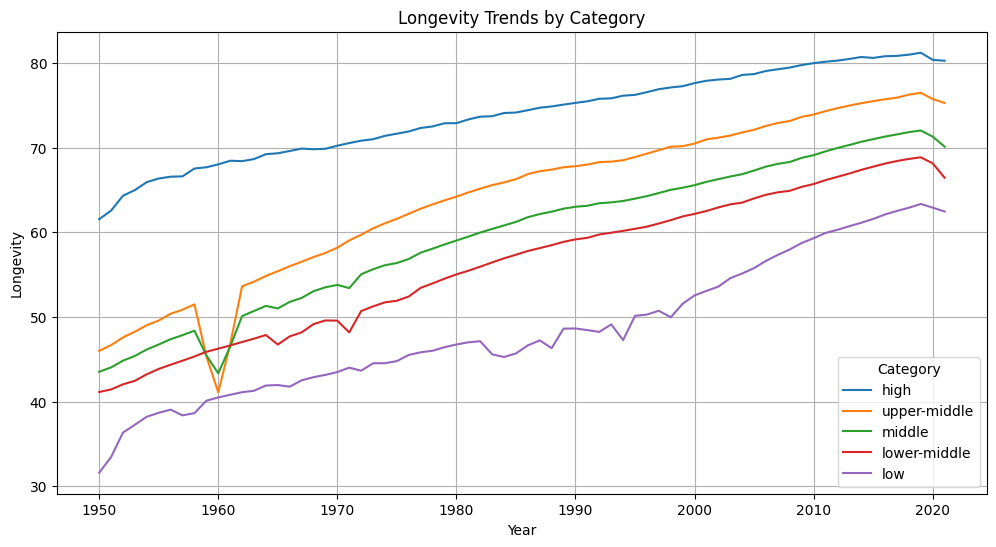

In [37]:
df = query(conn, "SELECT * FROM longevity_income")

plt.figure(figsize=(12, 6))

# Plot line for each category
for category in income_category[::-1]:
    subset = df[df['category'] == category]
    plt.plot(subset['year'], subset['longevity'], label=category)

# Adding titles and labels
plt.title('Longevity Trends by Category')
plt.xlabel('Year')
plt.ylabel('Longevity')
plt.legend(title='Category')

# Display the plot
plt.grid(True)
plt.show()

## Country developments

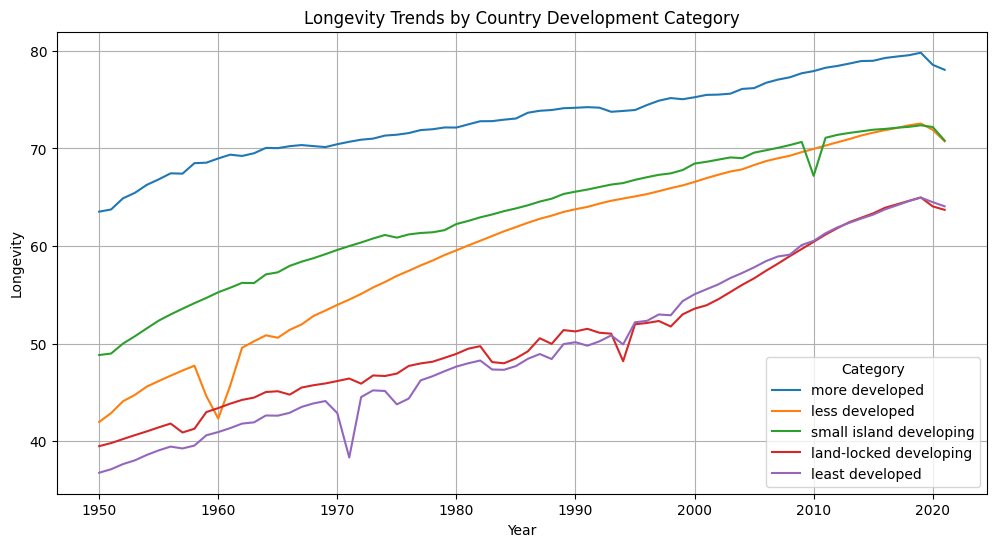

In [38]:
df = query(conn, "SELECT * FROM longevity_development")

plt.figure(figsize=(12, 6))

# Plot line for each category in the defined order
for category in development_category[::-1]:
    subset = df[df['category'] == category]
    # Plot and add the line with the category as the label
    plt.plot(subset['year'], subset['longevity'], label=category)

# Adding titles and labels
plt.title('Longevity Trends by Country Development Category')
plt.xlabel('Year')
plt.ylabel('Longevity')

# Add legend with title 'Category'
plt.legend(title='Category')

# Display the plot
plt.grid(True)
plt.show()


## Continent

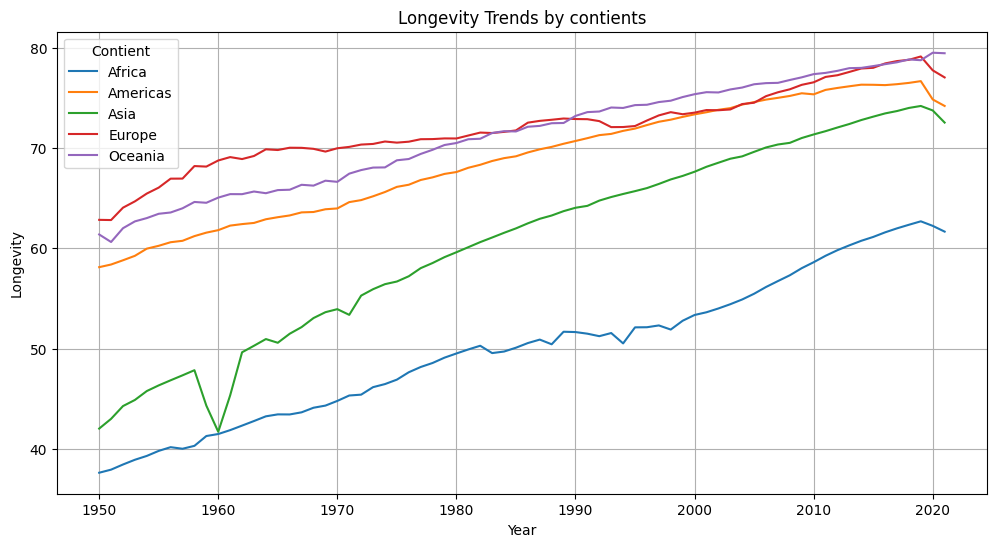

In [39]:
df = query(conn, "SELECT * FROM longevity_continent")

plt.figure(figsize=(12, 6))

# Plot line for each category in the defined order
for category in continent:
    subset = df[df['region'] == category]
    # Plot and add the line with the category as the label
    plt.plot(subset['year'], subset['longevity'], label=category)

# Adding titles and labels
plt.title('Longevity Trends by contients')
plt.xlabel('Year')
plt.ylabel('Longevity')

# Add legend with title 'Category'
plt.legend(title='Contient')

# Display the plot
plt.grid(True)
plt.show()


## World

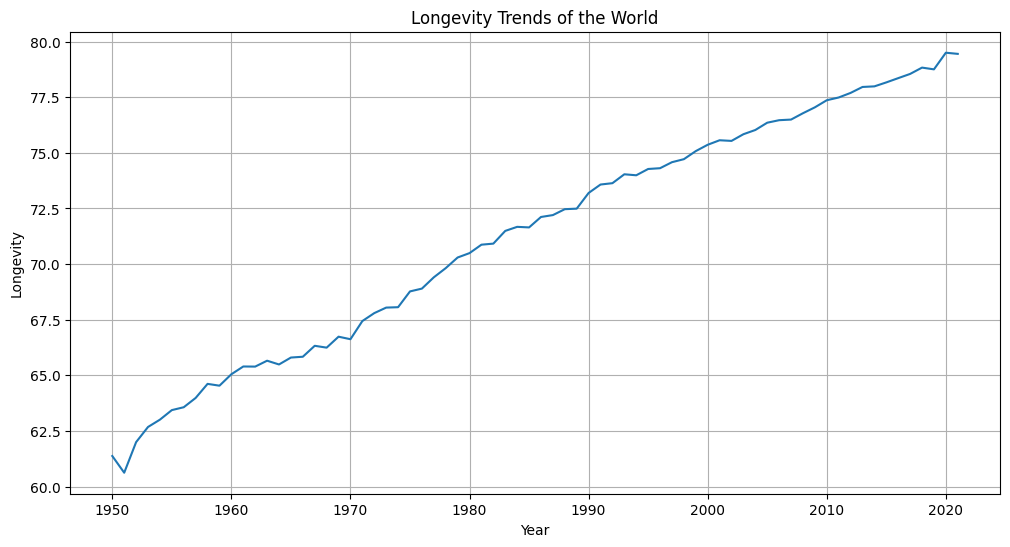

In [40]:
df = query(conn, "SELECT * FROM longevity_world")
plt.figure(figsize=(12, 6))

plt.plot(subset['year'], subset['longevity'])

# Adding titles and labels
plt.title('Longevity Trends of the World')
plt.xlabel('Year')
plt.ylabel('Longevity')

# Display the plot
plt.grid(True)
plt.show()


## Geodata

In [62]:
df_geodata = query(conn, """
        select l.iso_code, l.year, l.longevity, g.geom
        from longevity_country l
        inner join geom_country g using (iso_code)
        """)

df_geodata['geom'] = df_geodata['geom'].apply(lambda x: wkb.loads(x, hex=True))
df_geodata = gpd.GeoDataFrame(df_geodata, geometry = 'geom')

In [65]:
# Calculate the bounding box
boundary = df_geodata['geom'].total_bounds
[minx, miny, maxx, maxy] = boundary

# Initialize the map
m = folium.Map(
    tiles='Cartodb Positron',
    zoom_start=10,
    bounds=[[miny, minx], [maxy, maxx]],
    color='blue',
    fill=True,
    fill_opacity=0.1
)

# Happiness index

In [ ]:
df_happiness = pd.read_csv('data/happiness-index.csv')
df_happiness = df_happiness.drop(columns = ['Rank'])
df_happiness.columns = ['country', 'year', 'index']
df_happiness

,country,year,index
0,Afghanistan,2013,4.040
1,Afghanistan,2015,3.575
2,Afghanistan,2016,3.360
3,Afghanistan,2017,3.794
4,Afghanistan,2018,3.632
...,...,...,...
1518,Zimbabwe,2019,3.663
1519,Zimbabwe,2020,3.299
1520,Zimbabwe,2021,3.145
1521,Zimbabwe,2022,2.995


In [ ]:
df_happiness_iso_code = pd.merge(df_country_ref, df_happiness, on='country', how='outer')

# Filter the DataFrame where 'iso_code' or 'country' is null
filtered_df = df_happiness_iso_code[df_happiness_iso_code['iso_code'].isnull() | df_happiness_iso_code['country'].isnull()]

# Get unique values of 'iso_code' and 'country' columns
unique_iso_code = filtered_df['iso_code'].unique()
unique_country = filtered_df['country'].unique()

print("Unique iso_code values with null entries:", unique_iso_code)
print("Unique country values with null entries:", unique_country)

Unique iso_code values with null entries: [nan]
Unique country values with null entries: ['Congo Brazzaville' 'Congo Kinshasa' 'Ivory Coast' 'Kosovo'
 'North Cyprus' 'Somaliland' 'Swaziland' 'Turkiye']


In [ ]:
#Left everything else except Turkey
df_happiness_iso_code.loc[df_happiness_iso_code['country'] == 'Turkiye', 'iso_code'] = df_country[df_country['country'] == 'Turkey']['iso_code'].unique()[0]
df_happiness_iso_code = df_happiness_iso_code.dropna()
df_happiness_iso_code = df_happiness_iso_code.drop(columns=['country'])
df_happiness_iso_code

,iso_code,year,index
0,AFG,2013.0,4.040
1,AFG,2015.0,3.575
2,AFG,2016.0,3.360
3,AFG,2017.0,3.794
4,AFG,2018.0,3.632
...,...,...,...
1594,ZWE,2019.0,3.663
1595,ZWE,2020.0,3.299
1596,ZWE,2021.0,3.145
1597,ZWE,2022.0,2.995


In [ ]:
conn.execute(text("""
DROP TABLE IF EXISTS happiness CASCADE;
CREATE TABLE happiness (
    iso_code CHAR(3),
    year INTEGER,
    index FLOAT,
    PRIMARY KEY (iso_code, year)
);
"""))
df_happiness_iso_code.to_sql('happiness', conn, if_exists='append', index=False)
query(conn, "select * from happiness")

,iso_code,year,index
0,AFG,2013,4.040
1,AFG,2015,3.575
2,AFG,2016,3.360
3,AFG,2017,3.794
4,AFG,2018,3.632
...,...,...,...
1465,ZWE,2019,3.663
1466,ZWE,2020,3.299
1467,ZWE,2021,3.145
1468,ZWE,2022,2.995


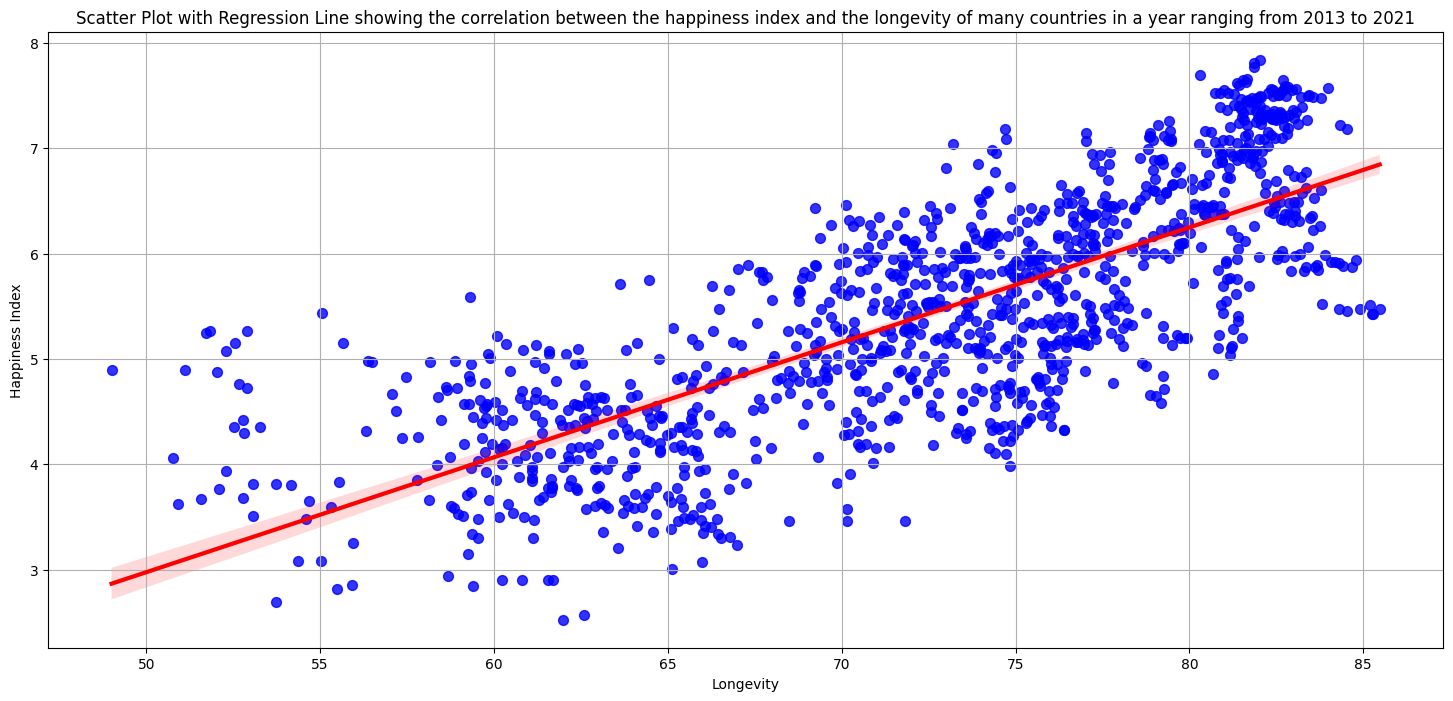

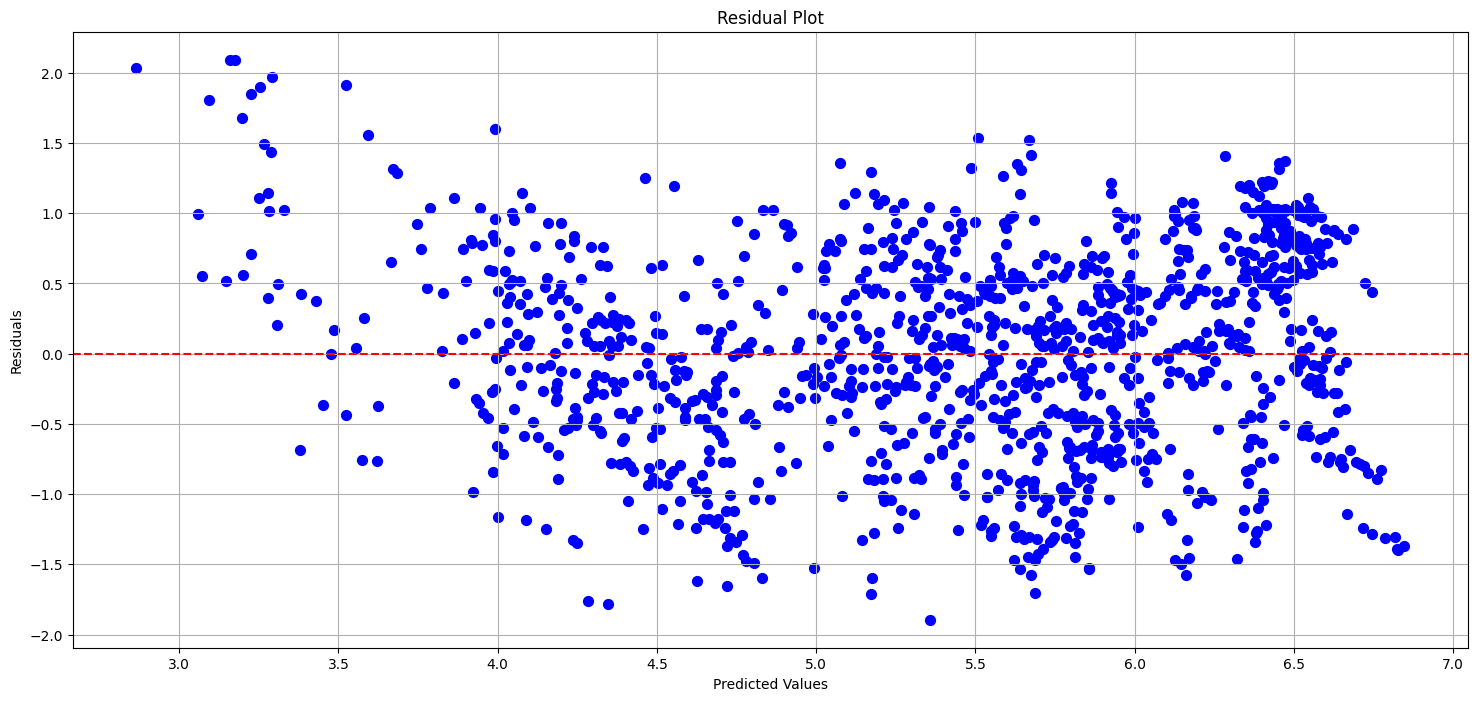

In [ ]:
df = query(conn, """
        select l.iso_code, l.year, l.longevity, h.index
        from longevity_country l
        inner join happiness h 
        on l.iso_code = h.iso_code and l.year = h.year
        """)
plt.figure(figsize=(18, 8))
sns.regplot(x='longevity', y='index', data=df, scatter_kws={'color':'blue', 's':50}, line_kws={'color':'red', 'linewidth':3})

# Customize and show the plot
plt.title('Scatter Plot with Regression Line showing the correlation between the happiness index and the longevity of many countries in a year ranging from 2013 to 2021')
plt.xlabel('Longevity')
plt.ylabel('Happiness Index')
plt.grid(True)
plt.show()


X = df['longevity']
y = df['index']

# Compute coefficients of the line y = mx + c
X_mean = X.mean()
y_mean = y.mean()
m = np.sum((X - X_mean) * (y - y_mean)) / np.sum((X - X_mean) ** 2)
c = y_mean - m * X_mean

# Predict y values
y_pred = m * X + c

# Calculate residuals
residuals = y - y_pred


plt.figure(figsize=(18, 8))
plt.scatter(y_pred, residuals, color='blue', s=50)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()



In [ ]:
correlation_coefficient = df['longevity'].corr(df['index'])
print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: 0.7640952826103466
